# Fit FELTOR magnetic field coefficients to experimental equilibrium

This notebook explains a possible way to convert an experimental magnetic field equilibrium to an input file for FELTOR. 

**At this point please read up on how FELTOR sets up the magnetic flux in the documentation "feltor/src/feltor/feltor.tex" (compile to pdf)** 

Here, we assume that we have given a matlab file containing an experimental profile from TCV that we want to fit using FELTOR's polynomial fit.

## Explore experimental data

First we want to explore the experimental data a bit

In [1]:
import numpy as np
import json
import scipy.io
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


In [2]:
# First we load the matlab file

file = "eq_TCV_76186"
# file = "eq_TCV_76142"
mat = scipy.io.loadmat(file+'.mat')

# and display its content
scipy.io.whosmat(file+'.mat')

[('eq', (1, 1), 'struct')]

In [3]:
# The 'eq' struct is a structured ndarray and contains several variables
mat['eq'].dtype.names

('Bpol', 'Bphi', 'R', 'Z', 'psi', 'BR', 'BZ', 'R_wall', 'Z_wall')

In [4]:
# Let us load the data 
print( "Loading data ... ")
# The first two 0s are because of how the data is stored
R= mat['eq']['R'][0][0][:,:]
Z= mat['eq']['Z'][0][0][:,:]
Psi = mat['eq']['psi'][0][0][:,:]
BR = mat['eq']['BR'][0][0][:,:]
BZ = mat['eq']['BZ'][0][0][:,:]
Bpol = mat['eq']['Bpol'][0][0][:,:]
Bphi = mat['eq']['Bphi'][0][0][:,:]
R_wall = mat['eq']['R_wall'][0][0] # not used for now
Z_wall = mat['eq']['Z_wall'][0][0] # not used for now
print(R.shape)

Loading data ... 
(1520, 540)


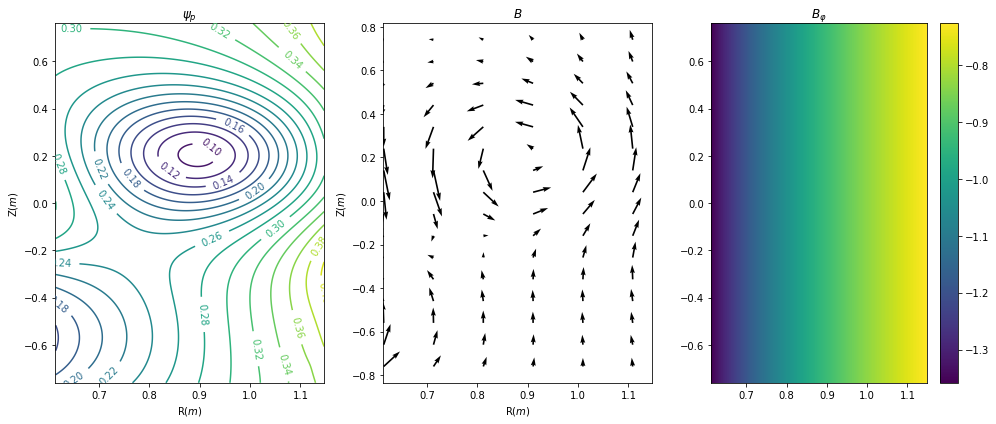

In [5]:
# Now let us plot the flux function 
# which is what we want to fit
# and the B - field

fig, axes = plt.subplots(nrows=1, ncols=3,sharex=True,
                         figsize=(14,6), squeeze=False)

ax = axes[0][0]
cf = ax.contour(R,Z,Psi,15)
ax.clabel(cf)
ax.set_xlabel(r'R($m$)')
ax.set_ylabel(r'Z($m$)')
ax.set_title(r'$\psi_p$')
ax = axes[0][1]
q = ax.quiver(R[::100,::100],Z[::100,::100],BR[::100,::100],BZ[::100,::100], units="width")
ax.set_xlabel(r'R($m$)')
ax.set_ylabel(r'Z($m$)')
ax.set_title(r'$B$')
ax = axes[0][2]
cf = ax.pcolormesh(R,Z,Bphi)
fig.colorbar(cf,ax=ax)
ax.set_title(r'$B_\varphi$')
fig.tight_layout()

plt.show()

In [6]:
# Let us also print the location of the O-point
o_point = np.where( Psi == np.min(Psi))
print("O-point at (R_O,Z_O) = ",R[o_point], Z[o_point])

O-point at (R_O,Z_O) =  [0.89582745] [0.20263331]


## Orientation and consistency

From an external documentation we know that the data bases on Cylindrical right handed coordinate system $R,\varphi,Z$ (i.e. $\hat e_\varphi$ is **anti-clock wise** if viewed from the top) 
and the magnetic field is given by
\begin{align}
\vec B = \frac{1}{R}\left( I \hat e_\varphi + \vec \nabla \psi \times \hat e_\varphi \right) = \frac{1}{R}\left( I \hat e_\varphi + \frac{\partial \psi}{\partial Z} \hat e_R - \frac{\partial \psi}{\partial R} \hat e_Z \right)
\end{align}

From the above plot we realize that with $B_\varphi <0$ **the toroidal field is clockwise** if viewed from the top. Together with the poloidal field we have a **right handed winding**. gradB of ions downwards, favourable for Hmode.

First we test if the contained magnetic field is consistent with the flux function and fulfills
\begin{align}
B_R = \frac{1}{R} \frac{\partial \psi}{\partial Z} \\
B_Z = -\frac{1}{R} \frac{\partial \psi}{\partial R} 
\end{align}

In [7]:
# Numerically derive
dPsidZ = np.diff( Psi, axis=0)/np.diff( Z, axis=0)
dPsidR = np.diff( Psi, axis=1)/np.diff( R, axis=1)
dPsidZ=np.append(np.zeros((1,(np.shape(Psi)[1]))),dPsidZ, axis=0)
dPsidR=np.append(np.zeros(((np.shape(Psi)[0]),1)),dPsidR, axis=1)
#print( np.shape(dPsidz))
BR_num = -1/R*dPsidZ
BZ_num =  1/R*dPsidR

# print the first element
print(abs(BR[1,0]-BR_num[1,0])/BR[1,0])
print(abs(BZ[1,1]-BZ_num[1,1])/BZ[1,1])

5.299454386934689
5.293297952211237


We see that the numerical derivative is different from the stored magnetic field. Through some experimentation we find out that there is a factor $2\pi$ in Psi that we need to divide.


In [8]:
Psi = Psi/2/np.pi

In [9]:
# Numerically derive
dPsidZ = np.diff( Psi, axis=0)/np.diff( Z, axis=0)
dPsidR = np.diff( Psi, axis=1)/np.diff( R, axis=1)
dPsidZ=np.append(np.zeros((1,(np.shape(Psi)[1]))),dPsidZ, axis=0)
dPsidR=np.append(np.zeros(((np.shape(Psi)[0]),1)),dPsidR, axis=1)
#print( np.shape(dPsidz))
BR_num = -1/R*dPsidZ
BZ_num =  1/R*dPsidR

# print the first element
print(abs(BR[1,0]-BR_num[1,0])/BR[1,0])
print(abs(BZ[1,1]-BZ_num[1,1])/BZ[1,1])

0.002589304462577562
0.001609477444532678


We consider the remaining difference negligible.

## Normalization and Transformtion

The first task is to normalize the data. FELTOR's polynomial 
fit uses
\begin{align}
 \frac{\psi}{B_0R_0^2} = P_\psi \sum_{ij=1}^{N_R,N_Z} c_{ij}\left(\frac{R}{R_0}\right)^i \left(\frac{Z}{R_0}\right)^j
 \end{align}
 
 This means we need to renormalize the dimensional experimental data.
 First we choose $R_0$ and $B_0$ to be the O-point values.
 Since these are only normalization coefficients their exact
 values are not important

In [10]:

R0 = np.round( R[o_point][0], decimals=2)
B0 = np.round(
    np.sqrt(Bphi[o_point]**2 + Bpol[o_point]**2)[0],
    decimals=2)
print(R0, B0)
# As minor radius we estimate from the above figure
a = 0.25 

0.9 0.93


The $P_\psi$ coefficient can be used to later change the direction
of the poloidal field

In [11]:
PP = 1

The next point is that FELTOR wants the O-point to be close to $(R_0, 0)$
Therefore we move the $Z$ coordinate by 0.2

In [12]:
Z0 = np.round( Z[o_point][0], decimals=2)
print(Z0)

0.2


Next, we need to consider that FELTOR's coordinate system is a 
right-handed $(R,Z,\varphi')$ (instead of $(R,\varphi,Z)$, which means that FELTOR's $\hat e_\varphi' = - \hat e_\varphi$ points **clockwise** if viewed from the top and we have
  \begin{align}
\vec B = \frac{1}{R}\left( I \hat e_\varphi' + \vec \nabla \psi \times \hat e_\varphi' \right) = \frac{1}{R}\left( I \hat e_\varphi' - \frac{\partial \psi}{\partial Z} \hat e_R + \frac{\partial \psi}{\partial R} \hat e_Z \right)
\end{align} 

We thus need to make the identification
\begin{align}
\psi \rightarrow -\psi \\
I \rightarrow -I \\
B_\varphi \rightarrow - B_\varphi
\end{align}

Now, reread the data with normalizations. In this way we avoid double normalization if we execute the cell twice by accident.

In [13]:
# Normalization
R= mat['eq']['R'][0][0][:,:]/R0
Z= mat['eq']['Z'][0][0][:,:]/R0 - Z0
Psi = -mat['eq']['psi'][0][0][:,:]/2/np.pi/R0**2/B0
BR = mat['eq']['BR'][0][0][:,:]/B0
BZ = mat['eq']['BZ'][0][0][:,:]/B0
Bpol = mat['eq']['Bpol'][0][0][:,:]/B0
Bphi = -mat['eq']['Bphi'][0][0][:,:]/B0

Now, everything is in FELTOR coordinates.

## The fit

First we need to define the fit function in python and fit the coefficients. In order to accelerate the fit it is also a good idea
to not take all points. It is sufficient to only take every 10th point say

In [14]:
miny=0 # 100
maxy=-1 # 1300
minx=0 # 40
maxx=-1 #540
every=8
R= mat['eq']['R'][0][0][miny:maxy:every,minx:maxx:every]/R0
Z= mat['eq']['Z'][0][0][miny:maxy:every,minx:maxx:every]/R0-Z0
Psi = -mat['eq']['psi'][0][0][miny:maxy:every,minx:maxx:every]/2/np.pi/R0**2/B0
BR = mat['eq']['BR'][0][0][miny:maxy:every,minx:maxx:every]/B0
BZ = mat['eq']['BZ'][0][0][miny:maxy:every,minx:maxx:every]/B0
Bpol = mat['eq']['Bpol'][0][0][miny:maxy:every,minx:maxx:every]/B0
Bphi = -mat['eq']['Bphi'][0][0][miny:maxy:every,minx:maxx:every]/B0


In [15]:
# The degree of the polynomial determines how long the fitting
# takes but also how good the fit will be
degR = 10
degZ = 10
def psi_ana( x, *c):
#    print(x)
    R , Z = x
    psi = np.zeros([degR*degZ,np.size(R)])
    for i in range( degR):
        for j in range (degZ):
            psi[i*degZ+j] = R**i*Z**j

    return np.dot(c,psi)

In [16]:
# With this function we can experiment to weigh the fitting 
# Let's ignore it for now

def sigma ( x): 
    # if x < 0.07:
    #     return 10000 #basically removes these points from fit
    # if x > 0.56/2/np.pi:
    #     return 1
    # else:
        return 1

In [17]:
c = np.array( np.zeros(degR*degZ))

#We need to ravel the meshgrids of X, Y points
# to a pair of 1-D arrays:
coords = np.vstack((R.ravel(),Z.ravel()))
psip_exp = Psi.ravel()
# in case we have a sigma
weights = np.array([sigma(psi) for psi in psip_exp])


In [18]:
# Here comes the fit (might take a while)
copt, pcov = curve_fit(psi_ana, coords, psip_exp,c,weights)   
print( copt)

[-1.81333722e+00  1.64161992e+00  2.31067572e+01  6.47080310e+00
 -4.40370676e+01 -1.82062982e+01  2.56560912e+01  3.90992929e+00
  2.26097940e+01  3.07124528e+01  4.73596407e+00 -7.59887189e+00
 -1.19308927e+02 -5.50765148e+01  2.06491285e+02  1.09163107e+02
 -1.77288440e+02 -5.55276466e+01 -4.42370709e+01 -1.08455364e+02
  1.11917060e+01  1.10507146e+01  2.14575796e+02  1.60341890e+02
 -2.14339412e+02 -1.66183332e+02  2.94098030e+02  7.94134041e+01
 -1.38323345e+01  1.42703541e+02 -6.16873899e+01  7.00898146e+00
 -1.42430695e+02 -2.25674507e+02 -2.86961588e+02 -4.43042586e+01
  5.58493338e+01  1.24525445e+02  4.56921464e+00 -9.87987159e+01
  9.61850962e+01 -4.57603275e+01  4.13520041e+01  1.61342408e+02
  5.63970123e+02  2.31460158e+02 -3.86655842e+02 -2.40712709e+02
  1.77750576e+02  2.70816277e+01 -6.22319091e+01  6.44630821e+01
 -1.07686361e+02 -1.21938296e+01  3.70089303e+00 -2.66025803e+01
  6.84819654e+01 -1.90446732e+00 -2.60362229e+02  4.70457387e+01
  9.35492386e+00 -3.88943

Let's see how good the fit is

In [19]:
psip_ana = psi_ana( coords, copt)
psip_ana = psip_ana.reshape( R.shape)
difference = psip_ana-Psi
print("Relative Error in Psi is      ",
      np.linalg.norm(difference, ord=2)/np.linalg.norm(
          Bphi.ravel(), ord=2))

Relative Error in Psi is       0.00037344666425904245


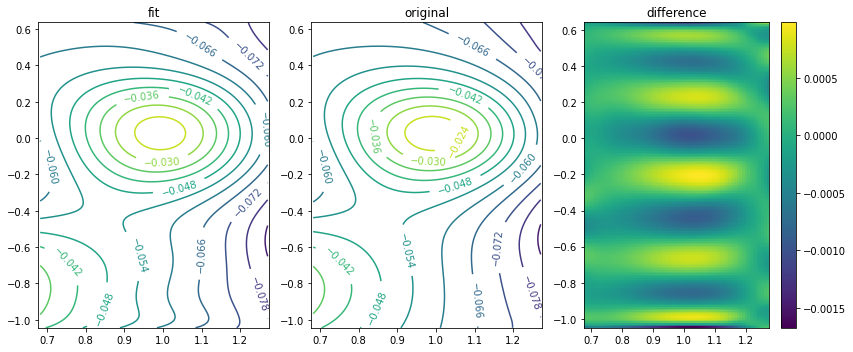

In [20]:
# Plot the numerical result, the original Psi and the difference
# In NORMALIZED UNITS
fig, axes = plt.subplots(nrows=1, ncols=3,sharex=True,
                         figsize=(12,5), squeeze=False)

ax = axes[0][0]
cf = ax.contour(R,Z,psip_ana,11)
ax.clabel(cf)
ax.set_title('fit')
ax = axes[0][1]
cf = ax.contour(R,Z,Psi,11)
ax.clabel(cf)
ax.set_title('original')
ax = axes[0][2]
cf = ax.pcolormesh(R,Z,(psip_ana-Psi))
ax.set_title('difference')
fig.colorbar(cf,ax=ax)
fig.tight_layout()

plt.show()

## The toroidal B
In the polynomial FELTOR fit the toroidal field is simply given by
\begin{align}
B_t = \frac{P_I}{R} \hat e_\varphi'
\end{align}
Where $P_I= \pm 1$ gives the direction of the field

In [21]:
PI = 1

In [22]:
#Bphi_ana = np.sqrt( 1-2*copt[13]/copt[12]**2 *psip_num)#/coords[0]
Bphi_ana = PI/R
difference = Bphi - Bphi_ana
print("Relative Error in Bphi is      ",
      np.linalg.norm(difference, ord=2)/np.linalg.norm(
          Bphi.ravel(), ord=2))
Bphi_ana = Bphi_ana.reshape( R.shape)
#source = source.reshape( R.shape)

Relative Error in Bphi is       0.003587664956444068


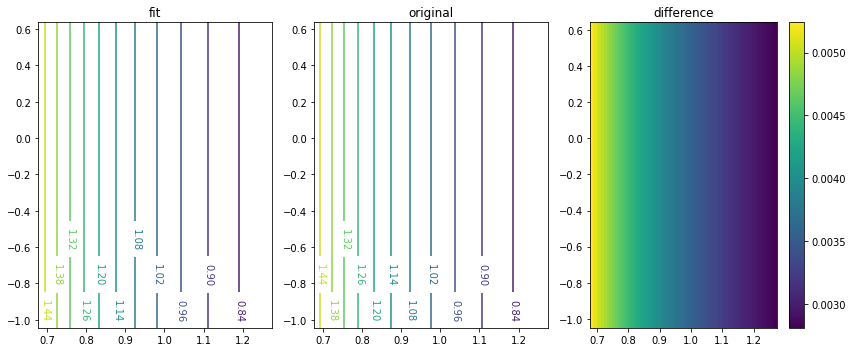

In [23]:
# Plot the numerical result
fig, axes = plt.subplots(nrows=1, ncols=3,sharex=True,
                         figsize=(12,5), squeeze=False)

ax = axes[0][0]
cf = ax.contour(R,Z,Bphi_ana,11)
ax.clabel(cf)
ax.set_title('fit')
ax = axes[0][1]
cf = ax.contour(R,Z,Bphi,11)
ax.set_title('original')
ax.clabel(cf)
ax = axes[0][2]
pc = ax.pcolormesh(R,Z,(Bphi_ana-Bphi))
ax.set_title('difference')
fig.colorbar(pc,ax=ax)
fig.tight_layout()

plt.show()

We see that the toroidal magnetic field fits very well

## Final Steps

We are now ready to write the coefficients to a file.
Read the documentation of
[`dg::geo::createMagneticField`](https://mwiesenberger.github.io/feltor/geometries/html/group__geom.html#gaa0da1d1c2db65f1f4b28d77307ad238b) to find out about valid fields in your `json` file

In [24]:
geom_file = {
    "M" : degR, "N": degZ,  "c": copt.tolist(), 
    "PP": PP, 
    "PI": PI, 
    "R_0": R0, # R0 in m
    "elongation": 1.6, # an estimation from external source
    "triangularity": 0.3, # an estimation from external source
    "inverseaspectratio": a/R0,
    "equilibrium" : "polynomial", # the fit function we used
    "description": "standardX" # we only have one X-poin
}
# print(json.dumps(geom_file, indent=4))
with open(file+'.json', 'w') as f:
    print( json.dumps(geom_file, indent=4), file=f)


## Don't forget
FELTOR wants the X-point to lie on the $\psi_p=0$ line.
To this end we need
to find the X-point and subtract the $\psi_X$ value
from the $c_{00}$ coefficient. This is done by the *normalize_params.cpp* program that you should compile now. Then you can either run it by hand on the just created file or execute the following cell

In [25]:
import subprocess # to run the create program
try :
    process = subprocess.run(
        ["./normalize_params", file+'.json', file+'.json'],
            check=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE)

#     print( process.stdout)
except subprocess.CalledProcessError as e:
    print( e.stderr)



WELL DONE!! Now continue with *geometry_diag.ipynb* to setup up the
simulation box for the simulation!